# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: Alessandro Sottile

**Matricola**: 1873637

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

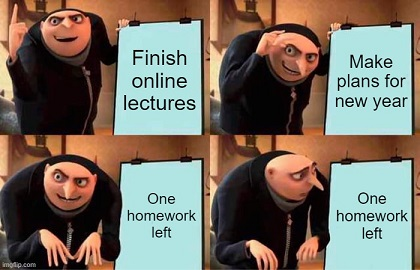

In [ ]:
import tensorflow as tf

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

The dataset chosen for this homework is [**Corn and Maize Leaf Disease Dataset**](https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset) from kaggle. The authors of this dataset created it using the PlantVillage and PlantDoc datasets. In this dataset we have 4188 images divided into four classes, representing some of the different states the plant leaf can be in:

* Common Rust - 1306 images
* Gray Leaf Spot - 574 images
* Blight -1146 images
* Healthy - 1162 images


The idea of using this dataset stems from my interest in plants. Moreover, maize being a plant used all over the world, the ability to recognise diseases promptly can avoid unpleasant scenarios.

The task is Image Classification.

I used my personal profile colab pro to run points 2 and 3.


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses, metrics, optimizers, callbacks
import numpy as np
from tqdm import tqdm
import os
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# let's define height and width for images
image_height = 180
image_width = 180

# let's set the batch size equal to 32
batch_size=32

In [ ]:
# upload the dataset from my drive folder
dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/NNDS/data_hw2",
    image_size=(image_height, image_width),
    batch_size= 32,
    label_mode='categorical'
)

Found 4188 files belonging to 4 classes.


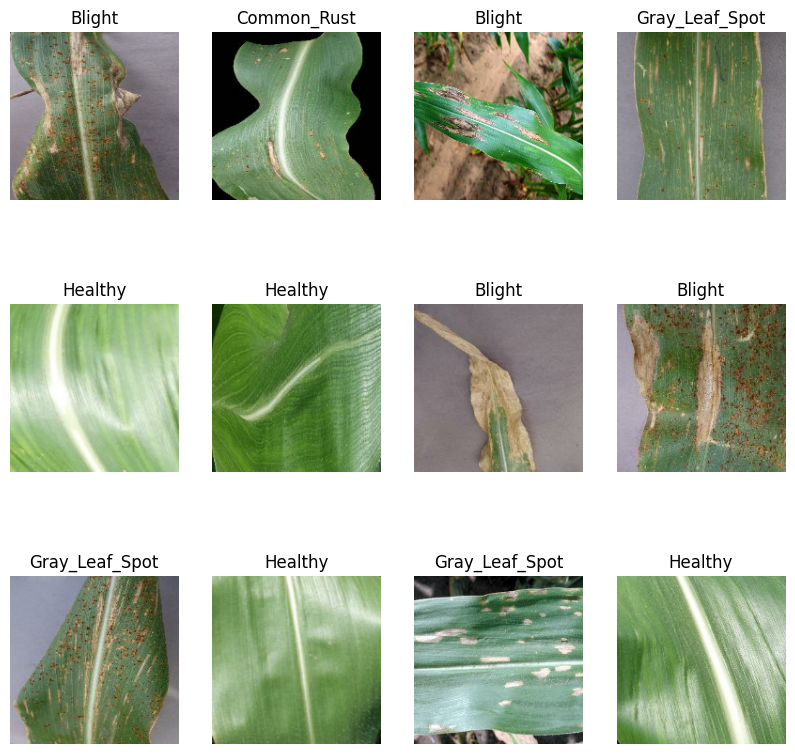

In [ ]:
# let's plot a sample of images from my data

label_names = sorted(os.listdir('/content/drive/MyDrive/NNDS/data_hw2'))
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        label_index = np.argmax(label_batch[i])
        plt.title(label_names[label_index])
        plt.axis('off')

Since my dataset is not stored separately in train/validation/test i did it myself. I divided the data as follows:

*   70% train set
*   15% validation set
*   15% test set




In [ ]:
# let's compute the cardinality of my data
length_dataset = dataset.cardinality().numpy()

# let's shuffle the dataset
tf.random.set_seed(1999)
dataset = dataset.shuffle(length_dataset, reshuffle_each_iteration=False)

# obtain the number of mini batches for each sub-portion of the dataset
train_samples = int(0.7*length_dataset)
val_samples = int(0.15*length_dataset) + 1 # otherwise validation and test set are unbalanced (19 and 21)
test_samples = length_dataset - train_samples - val_samples

print("Number of batches per subset:")
print("Train set:", train_samples)
print("Validation set:", val_samples)
print("Test set:", test_samples)

Number of batches per subset:
Train set: 91
Validation set: 20
Test set: 20


In [ ]:
# creation of the three datasets
train_dataset = dataset.take(train_samples)
val_dataset = dataset.skip(train_samples).take(val_samples)
test_dataset = dataset.skip(train_samples + val_samples)

 Data Augmentation procedures:
 I chose to practice some data augmentation techniques to improve the training of my models. First, i rescaled the image pixels to be in the [0,1] range. Then I applied some trasformations (Rotations, Flips, Zooms and Contrast) to make my models more invariant to transormations.
 I followed the [Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=it#overview) as guide in this part.

In [ ]:
# map the pixel values into [0,1] space
data_rescalation =  tf.keras.Sequential([
  layers.Rescaling(1./255)
])

# apply random transformations to make the network more robust to transformations
data_augmentation = tf.keras.Sequential([

    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(height_factor = (0.3)),
    layers.RandomContrast(0.15)
  ])

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def preparation(ds, augment=False):

  # Rescale all datasets.
  ds = ds.map(lambda x, y: (data_rescalation(x), y),
              num_parallel_calls=AUTOTUNE)


  # data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# let's apply the mods to the images inside my datasets
train_dataset_p = preparation(train_dataset, True)
val_dataset_p = preparation(val_dataset,False)
test_dataset_p = preparation(test_dataset, False)

### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

I decided to use a Convolutional neural network with 4 convolutional block, a global average pooling layer and a classification block. Each convolutional block is made in this way:

* 2D convolutional layer
* Batch Normalization
* Relu as activaction function
* Max pooling layer

I took inspiration from the CNN built in lab 2

In [ ]:
def conv_block(input, filters, k_size, stride_val):
  """ This function apply a convolutional block to an input
  Args:
  - input:
  - filters: number of filters
  - k_size: kernel size
  - stride_val: dimension of the stride

   Returns:
    - x: the output of the convolutional block
  """
  # apply a 2D convolutional layer to the input of the block
  i = layers.Conv2D(filters, kernel_size=(k_size, k_size), strides=(stride_val, stride_val))(input)

  # batch normalization
  x = layers.BatchNormalization()(i)

  # activaction function
  x = tf.nn.relu(x)

  # max pooling
  x = layers.MaxPool2D(2)(x)

  return x

In [ ]:
def build_model():

  """ This function will build a model made in the following way:

      CONV Block 1 --> CONV Block 2 --> CONV Block 3 --> CONV Block 4 --> Global Average Pooling --> Classification Block

      Returns:
    -  the model

  """
  # Input
  inp = layers.Input(shape=(180, 180, 3))

  # CONV Block 1
  x = conv_block(inp, 32, 3, 1)    # Output shape: (None, 89, 89, 32)

  # CONV Block 2
  x = conv_block(x, 64, 3, 1)      # Output shape: (None, 43, 43, 64)

  # CONV Block 3
  x = conv_block(x, 128, 3, 1)     # Output shape: (None, 20, 20, 128)

  # CONV Block 4
  x = conv_block(x, 256, 3, 1)     # Output shape: (None, 9, 9, 256)

  # Global Average Pooling
  x = layers.GlobalAvgPool2D()(x)  # Output shape: (None, 256)

  # Classification Block
  x = tf.keras.layers.Flatten()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(32)(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(4, activation='softmax')(x)   # Output shape: (None, 4)

  return tf.keras.Model(inputs=inp, outputs=x)

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496 

In [ ]:
# Compile the model with a lr = 0.0001, categorical_cross_entropy loss and accuracy as metric
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

# callback to save best model according to the validation accuracy
checkpoint_filepath = "/content/drive/MyDrive/NNDS/model1"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Let's check the GPU
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
# Train the model
history = model.fit(train_dataset_p, epochs = 20, validation_data = val_dataset_p, callbacks=[model_checkpoint_callback])

Epoch 1/20
92/92 [==============================] - 63s 379ms/step - loss: 0.7353 - accuracy: 0.7171 - val_loss: 1.3546 - val_accuracy: 0.2932
Epoch 2/20
92/92 [==============================] - 45s 345ms/step - loss: 0.4904 - accuracy: 0.7989 - val_loss: 1.2989 - val_accuracy: 0.3583
Epoch 3/20
92/92 [==============================] - 53s 426ms/step - loss: 0.4445 - accuracy: 0.8217 - val_loss: 1.2069 - val_accuracy: 0.3795
Epoch 4/20
92/92 [==============================] - 51s 424ms/step - loss: 0.3906 - accuracy: 0.8550 - val_loss: 1.1707 - val_accuracy: 0.3990
Epoch 5/20
92/92 [==============================] - 44s 335ms/step - loss: 0.3600 - accuracy: 0.8587 - val_loss: 0.7035 - val_accuracy: 0.7068
Epoch 6/20
92/92 [==============================] - 43s 334ms/step - loss: 0.3468 - accuracy: 0.8651 - val_loss: 0.3296 - val_accuracy: 0.9072
Epoch 7/20
92/92 [==============================] - 50s 420ms/step - loss: 0.3552 - accuracy: 0.8621 - val_loss: 0.2784 - val_accuracy: 0.9055

✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

I decided to plot the loss and accuracy curves both for the training and validation set. We can see how, even after only a few epochs, the model immediately begins to perform well. The model manages to achieve good results in both loss and accuracy.

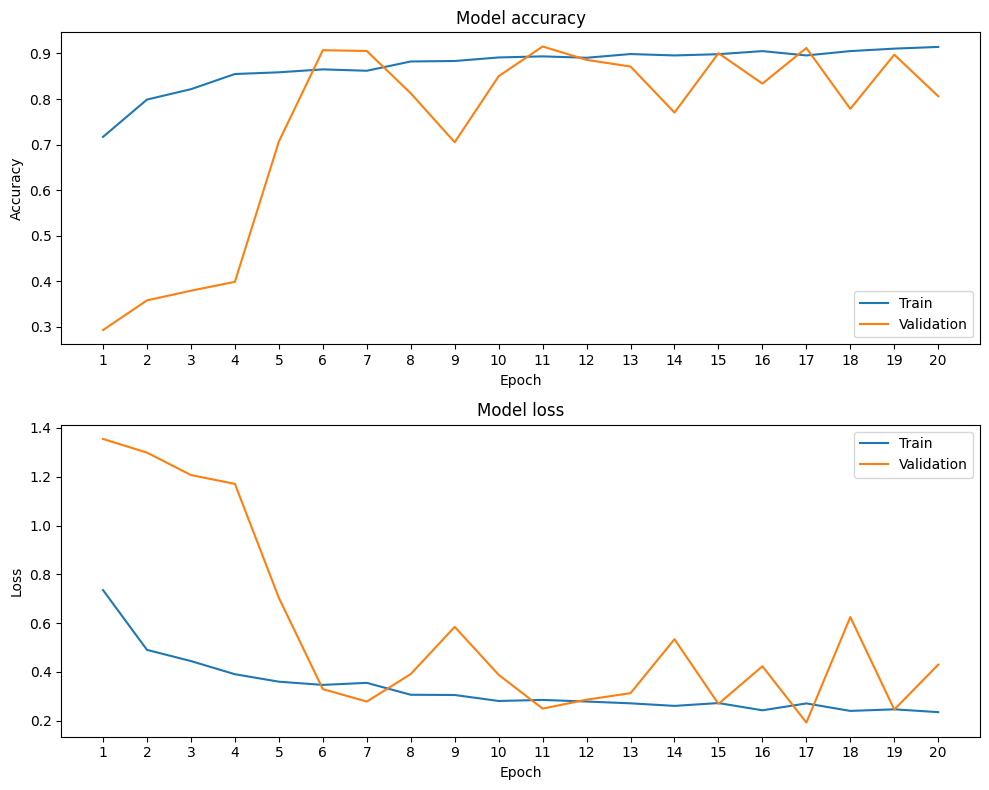

In [ ]:

# Set figure size
plt.figure(figsize=(10, 8))

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # Create subplot for accuracy
plt.plot(range(1, 21), history.history['accuracy'])
plt.plot(range(1, 21), history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(1, 21))
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # Create subplot for loss
plt.plot(range(1, 21), history.history['loss'])
plt.plot(range(1, 21), history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(1, 21))
plt.legend(['Train', 'Validation'], loc='upper right')

# Adjust layout spacing
plt.tight_layout()

# Display the plots
plt.show()


In addition, I wanted to evaluate the model saved in my drive previously on the test set. we can see that it has a good value in this dataset as well. so the best model has an accuarcy of 91,5% in the validation set and a value of 89,5% in the test set.

In [ ]:
model.load_weights('/content/drive/MyDrive/NNDS/model1')
model.evaluate(test_dataset_p)

20/20 [==============================] - 12s 23ms/step - loss: 0.2800 - accuracy: 0.8953


[0.2799595594406128, 0.895312488079071]

### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the model (what you implemented, bibliographic references, how you are training it, notable implementation issues, etc.).*

**TODO**: add a complete description here (2-3 paragraphs).

I decided to follow variant 2a (Early-exits), I used the lecture slides as a guide for the theory behind this point. Instead, I followed the [Tensorflow tutorial](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing) to build the class for the model and for the gradient computation.

I have therefore taken the architecture of the convolutional network defined in the previous point, in which however I have added two early exit blocks. the first inserted after the second convolutional block and the other after the third convolutional block. Each of the early exit blocks I have defined is designed as follows:

* FC layer with 256 units
* Dropout(0.3)
* FC layer with 3 units (the number of all the possible exits)

This model has different behavior in training time and inference time:

**Training time**:

 The model explores all the exits and the total loss is computed in this way:

 $$
Total\_Loss = loss(\hat{Y}, Y) + \sum_i{h_{e_i} loss(\hat{Y_{e_i}}, Y)}
$$
Where, in my case I have only two early exits and the relative $h_{e_i}$ are 0.6 for the first exit and 0.8 for the second. Because in my opinion a mistake on the second exit should be penalised more than one made on the first exit.


**Inference time**:

In both the exit layers, for each image in input the model computes the entropy ($H$) according the following formula:
$$
H = -\sum_c{y_c \log(y_c)}
$$
The image will exit from the model through early exit in which this condition is respected:
$
H < \gamma
$

Where $\gamma$ is a fixed value which I chose equal to 0.35 after some testing.

Practically speaking, to write in the form of code this part, for each batch I initialize a tensor of zeros that I go to fill as I go with the images that come out of each output inserted in the right position. The two functions I have defined help me to do this:
* udate_tensor() I use to do the update of the tensor that I initialized at the beginning.

* translation() I need to "translate" the indices in order to insert in the right place of the initial tensor the updates. infact after removing from the tensor x the images that came out in the previous exit obviously the indices of the tensor no longer match the orginial ones.



In [ ]:
def update_tensor(tensor,exits,tensor_indeces,exits_indices,h=0):
  """
  This function is used for update the tensor that we define for each minibatch

  Args:
    - tensor: the tensor that will be modified
    - exits: the tensor that will be used to update tensor
    - tensor_indices: the indices in the language of "tensor"
    - exits_indices: the indices in the language of "exits"
    - h: the value used to access the right tensor_indeces

  Returns
    - tensor: the tensor updated
  """
  for i in exits_indices:
             who_exit_ = exits[i]
             where= tensor_indeces[h]
             tensor = tf.tensor_scatter_nd_update(tensor, [[where]], [who_exit_])
             h = h+1
  return  tensor

In [ ]:
def translation(all_original_index, to_transalte, indices_removed):
  """
  This function is used for translate the indeces from the current notation to the original one (0,1,..,batch_size).
  Infact if we remove some rows from a tensor now the new indices will be (0,1,..,batch_size - rows_removed) and some indices no longer represent the exact same row as before.

  Args:
    - all_original_index: the list of the all the indices in the mini batch (0,1,..,batch_size)
    - to_transalte: the indices list that we want to transalte in the original notation
    - indices_removed: the indices removed in the previous steps

  Returns
    - translation: the list of the transalted indices
  """
  # if to_transalte is an empty list, the output will be an empty an empty list as well

  if not to_transalte:
    return []

  else:
    # build a list in wich we have only the element remains from all_original_index
    remains_from_original_list = [elem for elem in all_original_index if elem not in indices_removed]

    # initialize the list
    translation = []
    # append the translations
    for idx in to_transalte:
     translation.append(remains_from_original_list[idx])

    return translation

In [ ]:
class Cnn_Ee(tf.keras.Model):

    def __init__(self, num_classes=4):

        super().__init__()

        # 1 conv block
        self.conv1 = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.pool1 = layers.MaxPool2D(2)


        # 2 conv block
        self.conv2 = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.pool2 = layers.MaxPool2D(2)

        # 1 early exit block
        self.flatten_e1 = tf.keras.layers.Flatten()
        self.dense_e1 = layers.Dense(256, activation='relu')
        self.droput_e1 = layers.Dropout(0.3)
        self.classifier_e1 = layers.Dense(num_classes, activation='softmax')

        # 3 conv block
        self.conv3 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm3 = layers.BatchNormalization()
        self.act3 = layers.ReLU()
        self.pool3 = layers.MaxPool2D(2)

        # 2 early exit block
        self.flatten_e2 = tf.keras.layers.Flatten()
        self.dense_e2 = layers.Dense(256, activation='relu')
        self.droput_e2 = layers.Dropout(0.3)
        self.classifier_e2 = layers.Dense(num_classes, activation='softmax')

        # 4 conv block
        self.conv4 = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm4 = layers.BatchNormalization()
        self.act4 = layers.ReLU()
        self.pool4 = layers.MaxPool2D(2)

        # Global Pooling
        self.globalpooling = layers.GlobalAvgPool2D()

        # Flatten
        self.flatten = tf.keras.layers.Flatten()

        # Fc 1
        self.dense1 = layers.Dense(256, activation='relu')
        self.droput1 = layers.Dropout(0.3)

        # Fc 2
        self.dense2 = layers.Dense(32)
        self.droput2 = layers.Dropout(0.3)

        # Classification
        self.classifier = layers.Dense(num_classes, activation='softmax')



    def call(self, inputs, training=False):


      if training:

        #################
        # TRAINING TIME #
        #################

        # we explore all the exits and output all the predictions produced by each one

        # 1 conv block
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)


        # 2 conv block
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # 1 early exit block
        exit1 = self.flatten_e1(x)
        exit1 = self.dense_e1(exit1)
        exit1 = self.droput_e1(exit1)
        exit1 = self.classifier_e1(exit1)

        # 3 conv block
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.act3(x)
        x = self.pool3(x)

        # 2 early exit block
        exit2 = self.flatten_e2(x)
        exit2 = self.dense_e2(exit2)
        exit2 = self.droput_e2(exit2)
        exit2 = self.classifier_e2(exit2)

        # 4 conv block
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.act4(x)
        x = self.pool4(x)

        # Global Pooling
        x = self.globalpooling(x)

        # Flatten
        x = self.flatten(x)

        # Fc 1
        x = self.dense1(x)
        x = self.droput1(x)

        # Fc 2
        x = self.dense2(x)
        x = self.droput2(x)

        # Classification
        output = self.classifier(x)


        return [exit1, exit2, output]


      else:

        ##################
        # INFERENCE TIME #
        ##################

        # store the value of the current batch size
        batch_size = tf.shape(inputs)[0]

        # 1 conv block
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)


        # 2 conv block
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # 1 early exit block
        exit1 = self.flatten_e1(x)
        exit1 = self.dense_e1(exit1)
        exit1 = self.droput_e1(exit1)
        exit1 = self.classifier_e1(exit1)

        # let's initialize the output tensor with all zeros
        output_tensor = tf.zeros((batch_size , exit1.shape[1]), dtype=tf.float32)


        # compute the entropy H of each  input
        H1 = tf.map_fn(lambda row: -tf.reduce_sum(row * tf.math.log(row + 0.0001)), exit1)

        # select only the ones who respect the condition
        indices = tf.where(H1 <= 0.35).numpy()[:, 0].tolist()

        # Update the output_tensor with the predictions that meet the previous condition in the right indeces

        for i in indices:
          who_exit = exit1[i]
          output_tensor = tf.tensor_scatter_nd_update(output_tensor, [[i]], [who_exit])

        # if all the images came out in this exit, let's return the output_tensor and as distributions [batch_size,0,0]
        if len(indices) == x.shape[0]:
          exit_distribution= [len(indices), 0, 0]
          return output_tensor, exit_distribution

        # otherwhise
        else:

          # the original indices in the batch ([0,1,,,batch_size])
          idx_batch_original = list(range(x.shape[0]))
          # create a mask that selects all the indices of idx_batch_original that are not exited at the first early exit
          mask1 = np.isin(idx_batch_original, indices, invert=True)

          # select only the x that are in the mask1
          idx_to_preserve_1 = np.array(idx_batch_original)[mask1].tolist()
          x = tf.gather(x, idx_to_preserve_1, axis=0)


          # 3 conv block
          x = self.conv3(x)
          x = self.batch_norm3(x)
          x = self.act3(x)
          x = self.pool3(x)

          # 2 early exit block
          exit2 = self.flatten_e2(x)
          exit2 = self.dense_e2(exit2)
          exit2 = self.droput_e2(exit2)
          exit2 = self.classifier_e2(exit2)
          #print(exit2)


          # compute the entropy H of each  input
          H2 = tf.map_fn(lambda row: -tf.reduce_sum(row * tf.math.log(row + 0.0001)), exit2)

          # select only the ones who respect the condition
          indices2 = tf.where(H2 <= 0.35).numpy()[:, 0].tolist()

          # transalte the indices languages to the original iindices language of the batch
          indices_2_original_language = translation(list(range(batch_size)), indices2 , indices)


          # update the tensor
          output_tensor=update_tensor(output_tensor,exit2,indices_2_original_language,indices2,h=0)

          # if all the images came out in this exit, let's return the output_tensor and as distributions [indices, indices2, 0]
          if len(indices) + len(indices2) == x.shape[0]:
            exit_distribution= [len(indices), len(indices2), 0]
            return output_tensor, exit_distribution

          # otherwhise
          else:

            # the indices in the reming examples of the batch ([0,,,remaining_batch_size])
            idx_2 = list(range(x.shape[0]))
            # create a mask that selects all the indices of idx_2 that are not exited at the second early exit
            mask2 = np.isin(idx_2, indices2, invert=True)

            # select only the x that are in the mask1
            idx_to_preserve_2 = np.array(idx_2)[mask2].tolist()
            x = tf.gather(x, idx_to_preserve_2, axis=0)

            # 4 conv block
            x = self.conv4(x)
            x = self.batch_norm4(x)
            x = self.act4(x)
            x = self.pool4(x)

            # Global Pooling
            x = self.globalpooling(x)

            # Flatten
            x = self.flatten(x)

            # Fc 1
            x = self.dense1(x)
            x = self.droput1(x)

            # Fc 2
            x = self.dense2(x)
            x = self.droput2(x)

            # Classification
            output = self.classifier(x)

            # the indices that represent the remains in the batch, so there are the ones who will exit at the end of the model
            indices_final = list(range(output.shape[0]))

            #  Calculate the total indices that were used in the previous two exits
            total_index_used =  indices + indices_2_original_language

            # finds indices corresponding to places that have not yet been filled in the output tensor
            insert_the_last_here =  [elem for elem in idx_batch_original if elem not in total_index_used ]

            # update for the last time the tensor
            output_tensor=update_tensor(output_tensor,output,insert_the_last_here,indices_final,h=0)

            # Calculates the distribution of image outputs in the batch during the inference time
            exit_distribution = [len(indices),len(indices2),len(indices_final)]

            return output_tensor, exit_distribution


In [ ]:
# let's see if we have GPU to train the model
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
model = Cnn_Ee(num_classes=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
accuracy_metrics = [tf.keras.metrics.Accuracy() for i in range(3)]
val_accuracy = tf.keras.metrics.Accuracy()

# save the best model by val accuracy
stored_val_acc = 0
stored_model = None

In [ ]:
def mean_list(lista):
  """ it computes the mean of a list
  """
  mean = sum(lista) / len(lista)
  return mean

In [ ]:
# outputs of train time
train_Total_loss_epochs = []
train_loss_epochs_exit1 = []
train_loss_epochs_exit2 = []
train_loss_epochs_exit3 = []
train_accuracy_epochs_exit1 = []
train_accuracy_epochs_exit2 = []
train_accuracy_epochs_exit3 = []

# outputs of validation time

n_inference_exit_1 = []
n_inference_exit_2 = []
n_inference_exit_3 = []
val_loss_epochs = []
val_accuracy_epochs = []


epochs = 20
start_time = time.time()
for epoch in range(epochs):
    print("\nEpoch %d/%d" % (epoch + 1, epochs))

    ###############################
    ###########  TRAIN  ###########
    ###############################

    # empty lists to store the intermediate results
    total_loss_epoch =[]
    loss_predictions_exit1 =[]
    loss_predictions_exit2 =[]
    loss_predictions_exit3 =[]


    for  x_train, y_train in train_dataset_p:

        with tf.GradientTape() as tape:

            # Run the forward pass of the layer
            predictions= model(x_train, training=True)

            # Compute the losses values:

            #1 loss of the first exit
            l_exit1 = tf.keras.losses.CategoricalCrossentropy()
            loss_exit_1 = l_exit1(y_train, predictions[0])

            #2 loss of the other early exit
            l_exit2 = tf.keras.losses.CategoricalCrossentropy()
            loss_exit_2 = l_exit2(y_train, predictions[1])

            #3 loss of the final exit
            l_ =  tf.keras.losses.CategoricalCrossentropy()
            loss_ = l_(y_train, predictions[2])

            # sum the three previous losses together
            loss = tf.math.reduce_sum([loss_  + 0.5*loss_exit_1 + 0.8*loss_exit_2])

            # store intermediate results
            total_loss_epoch.append(loss.numpy())
            loss_predictions_exit1.append(loss_exit_1.numpy())
            loss_predictions_exit2.append(loss_exit_2.numpy())
            loss_predictions_exit3.append(loss_.numpy())

        # optimization
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # accuracies of the three possibile exits
        for i in range(3):
          accuracy_metrics[i].update_state(tf.argmax(y_train, axis=1), tf.argmax(predictions[i], axis=1))

    print("###################################  TRAIN  ###################################")
    print("Total_Loss: %.4f - Loss_Exit_1: %.4f - Loss_Exit_2: %.4f - Loss_Exit_3: %.4f " %  (mean_list(total_loss_epoch) ,mean_list(loss_predictions_exit1) , mean_list(loss_predictions_exit2) , mean_list(loss_predictions_exit3)))
    print("Accuracy_Exit_1: %.4f  Accuracy_Exit_2: %.4f Accuracy_Exit_3: %.4f " % ( float(accuracy_metrics[0].result()), float(accuracy_metrics[1].result()), float(accuracy_metrics[2].result()) ))

    # store the total loss
    train_Total_loss_epochs.append(mean_list(total_loss_epoch))


    # store all the losses
    train_loss_epochs_exit1.append(mean_list(loss_predictions_exit1))
    train_loss_epochs_exit2.append(mean_list(loss_predictions_exit2))
    train_loss_epochs_exit3.append(mean_list(loss_predictions_exit3))


    # store all the accuracies
    train_accuracy_epochs_exit1.append(float(accuracy_metrics[0].result()))
    train_accuracy_epochs_exit2.append(float(accuracy_metrics[1].result()))
    train_accuracy_epochs_exit3.append(float(accuracy_metrics[2].result()))



    # Reset training metrics at the end of each epoch
    for i in range(3):
     accuracy_metrics[i].reset_states()


    ####################################
    ###########  VALIDATION  ###########
    ####################################

    # empty lists to store the intermediate results
    final_distribution_exits = []
    val_loss =[]

    for  x_val, y_val in val_dataset_p:
      val_predictions, distr = model(x_val, training = False)

      # loss computation
      CE_val =  tf.keras.losses.CategoricalCrossentropy()
      loss_CE = CE_val(y_val, val_predictions)
      #print("preds",val_predictions)
      val_loss.append(loss_CE.numpy())

      # accuracy
      val_accuracy.update_state(tf.argmax(y_val, axis=1), tf.argmax(val_predictions, axis=1))
      current_val_accuracy = val_accuracy.result().numpy()

      # distribution of exits
      if not final_distribution_exits:  # if the list is empty
        final_distribution_exits = distr
      else:
        # for each batch of the same epoch, we add up all the images that come out output by output to get a distribution
        final_distribution_exits = [a + b for a, b in zip(final_distribution_exits, distr)]


    # compute the mean validation loss
    mean_val_loss = mean_list(val_loss)

    print("###################################  VALIDATION  ###################################")
    print("Loss : %.4f" % (mean_val_loss))
    print("Accuracy : %.4f" % (current_val_accuracy))
    print("Distribution of the exits:  Exit_1 : %.4f - Exit_2 : %.4f - Exit_3 : %.4f" %  (final_distribution_exits[0] ,final_distribution_exits[1] , final_distribution_exits[2] ))

    # store the loss and the accuarcy of the epoch
    val_loss_epochs.append(mean_val_loss)
    val_accuracy_epochs.append(current_val_accuracy)

    # store the exits distribution in the epoch
    n_inference_exit_1.append(final_distribution_exits[0])
    n_inference_exit_2.append(final_distribution_exits[1])
    n_inference_exit_3.append(final_distribution_exits[2])

    # update for the best model according to val accuracy
    if(current_val_accuracy >= stored_val_acc):
     stored_val_acc = current_val_accuracy
     stored_model = model

    # reset metric state
    val_accuracy.reset_states()

# print execution time
print("Total time: %s seconds" % (time.time() - start_time))


Epoch 1/20
###################################  TRAIN  ###################################
Total_Loss: 2.0701 - Loss_Exit_1: 1.3449 - Loss_Exit_2: 0.8102 - Loss_Exit_3: 0.7495 
Accuracy_Exit_1: 0.7146  Accuracy_Exit_2: 0.7421 Accuracy_Exit_3: 0.7077 
###################################  VALIDATION  ###################################
Loss : 1.3883
Accuracy : 0.2781
Distribution of the exits:  Exit_1 : 0.0000 - Exit_2 : 0.0000 - Exit_3 : 640.0000

Epoch 2/20
###################################  TRAIN  ###################################
Total_Loss: 1.1562 - Loss_Exit_1: 0.5180 - Loss_Exit_2: 0.4695 - Loss_Exit_3: 0.5216 
Accuracy_Exit_1: 0.7847  Accuracy_Exit_2: 0.8088 Accuracy_Exit_3: 0.7882 
###################################  VALIDATION  ###################################
Loss : 1.3464
Accuracy : 0.3656
Distribution of the exits:  Exit_1 : 0.0000 - Exit_2 : 0.0000 - Exit_3 : 640.0000

Epoch 3/20
###################################  TRAIN  ###################################
Total_

In [ ]:
# let's upload in my drive folder the best model according to val accuarcy
stored_model.save_weights('/content/drive/MyDrive/NNDS/model2')

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

From the graphs of losses and accuracies we can see that the model has been trained correctly, in fact as the epochs pass the losses go down and the accuarcies go up. we can see that the accuracy of the last output is higher than the second and in turn higher than the third.  Anyway, after the 12th epoch, all accuarcies rise above 80% and all losses (obviously except the total which is the sum of the three train losses) fall below 0.5

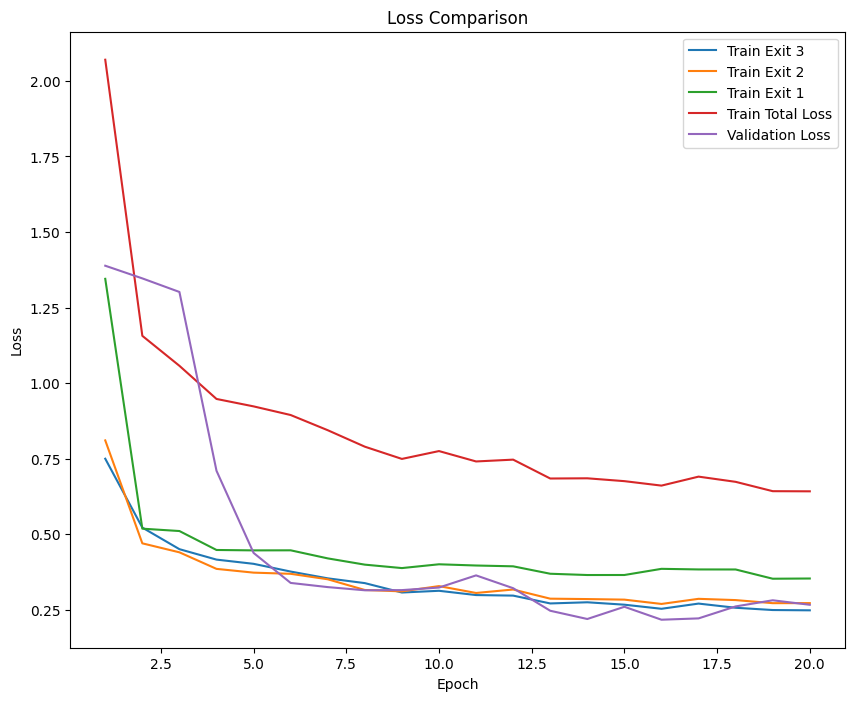

In [ ]:
x = range(1, 21)
plt.figure(figsize=(10, 8))

plt.plot(range(1, 21), train_loss_epochs_exit3, label='Train Exit 3')
plt.plot(range(1, 21), train_loss_epochs_exit2, label='Train Exit 2')
plt.plot(range(1, 21), train_loss_epochs_exit1, label='Train Exit 1')
plt.plot(range(1, 21), train_Total_loss_epochs, label='Train Total Loss')
plt.plot(range(1, 21), val_loss_epochs, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')

plt.legend()
plt.show()

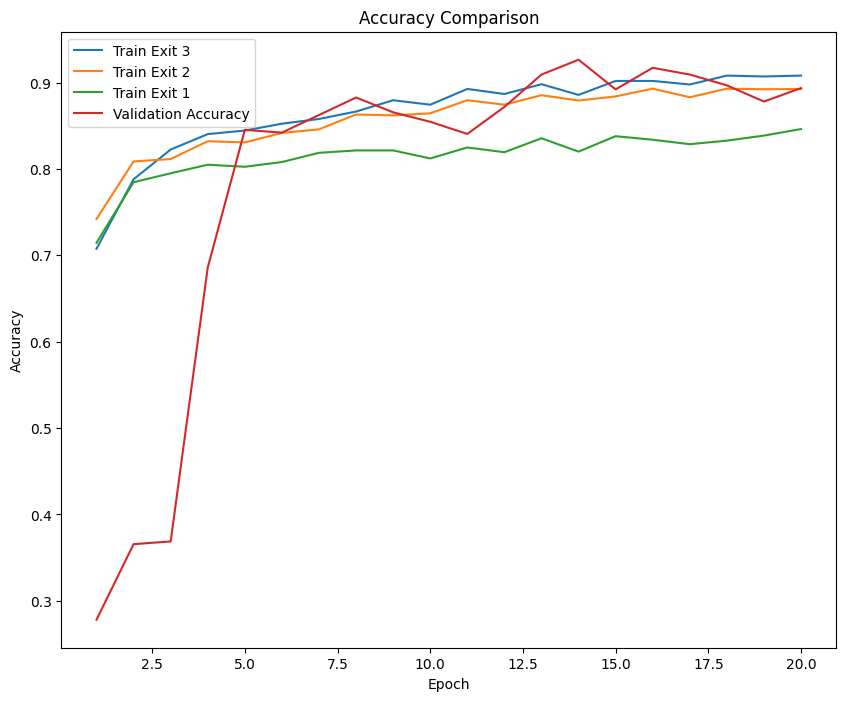

In [ ]:
x = range(1, 21)
plt.figure(figsize=(10, 8))




plt.plot(range(1, 21), train_accuracy_epochs_exit3, label='Train Exit 3')
plt.plot(range(1, 21), train_accuracy_epochs_exit2, label='Train Exit 2')
plt.plot(range(1, 21), train_accuracy_epochs_exit1, label='Train Exit 1')
plt.plot(range(1, 21), val_accuracy_epochs, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

plt.legend()
plt.show()

In the distribution of the outputs we can see, that in the first 2 epochs almost all the inputs are processed at the last exit, then the first exit is used more and more and from epoch 12 onwards it takes over. On the other hand the second output is always used very little. In my opinion this depends on the fact that as the epochs go by the entropy $H$ goes down in both early exits, but since exit 1 is the first one that every input encounters, this is where most of the inputs go out. Thus there remain the images where the model is not very secure and of these only a small portion comes out in the second early exit

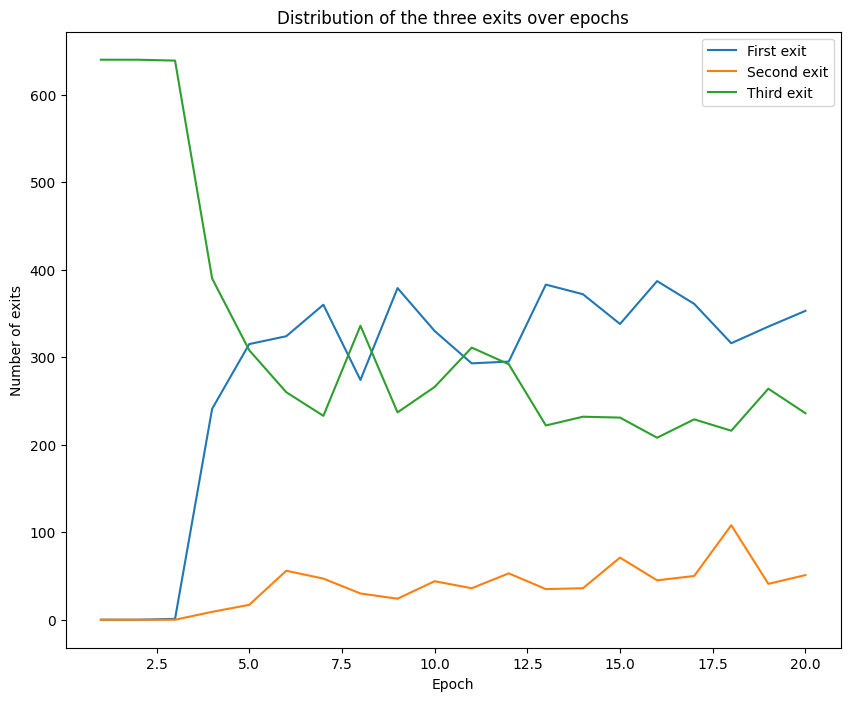

In [ ]:
x = range(1, 21)
plt.figure(figsize=(10, 8))
# Plot the lists
plt.plot(x, n_inference_exit_1, label='First exit')
plt.plot(x, n_inference_exit_2, label='Second exit')
plt.plot(x, n_inference_exit_3, label='Third exit')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Number of exits')
plt.title('Distribution of the three exits over epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/NNDS/model2')

The best model (the one saved in my drive previously) on the test set has a good accuracy value in this dataset as well: 87,5%.

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
for x_test, y_test in val_dataset_p:
  test_predictions = model(x_test, training = False)
  test_accuracy.update_state(tf.argmax(y_test, axis = 1), tf.argmax(test_predictions[0], axis = -1) )

print("Accuracy : %.4f "% test_accuracy.result())

Accuracy : 0.8750 


### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the regularization term you implemented.*

**TODO**: add description (1-2 paragraphs).

Since I implemented the early output model in step 2, I now have to balance the exits. To do this I have changed the network architecture of the previous model a little, inserting the exit selector block. this was defined by me by combining 3 fully connected layers and at the end a final classification layer. This block produces as output, for each input image, a probability distribution concerning which of the 3 exits of the model is the best fit to the input $i$:
$$p_i=[p_{e_1}, p_{e_2}, p_{e_3}]$$


The network again has different behaviour in training time and in inference time:


**Training time**:

The model explores for each image all the exits producing a tensor of predictions from each of them. Then, for each input, the predictions output by the model are a weighted average of the predictions received in the exits with the probabilities generated by the exits selection block as weights.

For each batch $j$ of data, we can calculate the averages of the probabilities of each output: $$\tilde{p_j}=[\tilde{p_{e_1}}, \tilde{p_{e_2}}, \tilde{p_{e_3}}]$$

By calculating the Kullback-Leibler Divergence between $\tilde{p_j}$ and a uniform distribution $\hat{p} = [0.333,0.333]$ we obtain a loss ($loss\_distr$) that will penalise the model if it makes the mean distribution of the images unbalanced between the three exits. The total loss is given by the simple sum of the EC loss on the predictions and the term just calculated.

**Inference time**:


For each image in the batch we apply $argmax$ to $p_i$ and thus each image is sent to the output that has the highest probability.
Practically speaking, as before for each batch I create a tensor of zeros that will collect the outputs in the various outputs, but knowing from the start which output each input is directed to, allows me to simplify the code.



In [ ]:
def insert_tensor(insert, new_tensor, row_ids):
  """
  This function is used for update the output_tensor that we define for each minibatch

  Args:
    - insert: the tensor that will be modified
    - new_tensor: the tensor that will be used to update output_tensor
    - row_ids: a list of indices that represent the id of the row that will be upadated

  Returns
    - output_tensor: the tensor updated
  """
  # if row_ids is empty:
  if not row_ids:
      return insert

  # if row_ids is only one single number:
  elif isinstance(row_ids, int):

      indices = [row_ids]

      output_tensor = tf.tensor_scatter_nd_update(insert, tf.expand_dims(indices, axis=1), new_tensor)

      return output_tensor

  # otherwise, if it is a list of values:
  else:
      indices = [[x] for x in row_ids]

      output_tensor = tf.tensor_scatter_nd_update(insert, indices, new_tensor)

      return output_tensor

In [ ]:
class Cnn_Ee_balanced(tf.keras.Model):

    def __init__(self, num_classes=4):

        super().__init__()

        # Exit_selector block
        self.flatten_selector = tf.keras.layers.Flatten()
        self.dense_selector = layers.Dense(1000, activation='relu')
        self.dense2_selector = layers.Dense(500, activation='relu')
        self.dense3_selector = layers.Dense(32, activation='relu')
        self.classifier_selector = layers.Dense(3, activation='softmax')


        # 1 conv block
        self.conv1 = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.pool1 = layers.MaxPool2D(2)


        # 2 conv block
        self.conv2 = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.pool2 = layers.MaxPool2D(2)

        # 1 early exit block
        self.flatten_e1 = tf.keras.layers.Flatten()
        self.dense_e1 = layers.Dense(256, activation='relu')
        self.droput_e1 = layers.Dropout(0.3)
        self.classifier_e1 = layers.Dense(num_classes, activation='softmax')

        # 3 conv block
        self.conv3 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm3 = layers.BatchNormalization()
        self.act3 = layers.ReLU()
        self.pool3 = layers.MaxPool2D(2)

        # 2 early exit block
        self.flatten_e2 = tf.keras.layers.Flatten()
        self.dense_e2 = layers.Dense(256, activation='relu')
        self.droput_e2 = layers.Dropout(0.3)
        self.classifier_e2 = layers.Dense(num_classes, activation='softmax')

        # 4 conv block
        self.conv4 = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm4 = layers.BatchNormalization()
        self.act4 = layers.ReLU()
        self.pool4 = layers.MaxPool2D(2)

        # Global Pooling
        self.globalpooling = layers.GlobalAvgPool2D()

        # Flatten
        self.flatten = tf.keras.layers.Flatten()

        # Fc 1
        self.dense1 = layers.Dense(256, activation='relu')
        self.droput1 = layers.Dropout(0.3)

        # Fc 2
        self.dense2 = layers.Dense(32)
        self.droput2 = layers.Dropout(0.3)

        # Classification
        self.classifier = layers.Dense(num_classes, activation='softmax')



    def call(self, inputs, training=False):

      if training:

        #################
        # TRAINING TIME #
        #################

        # exit selector block
        y_hat = self.flatten_selector(inputs)
        y_hat= self.dense_selector(y_hat)
        y_hat= self.dense2_selector(y_hat)
        y_hat= self.dense3_selector(y_hat)
        prob_y = self.classifier_selector(y_hat) # the probabilities of each exit

        # 1 conv block
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)


        # 2 conv block
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # 2 early exit block
        exit1 = self.flatten_e1(x)
        exit1 = self.dense_e1(exit1)
        exit1 = self.droput_e1(exit1)
        exit1 = self.classifier_e1(exit1)

        # 3 conv block
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.act3(x)
        x = self.pool3(x)

        # 3 early exit block
        exit2 = self.flatten_e2(x)
        exit2 = self.dense_e2(exit2)
        exit2 = self.droput_e2(exit2)
        exit2 = self.classifier_e2(exit2)

        # 4 conv block
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.act4(x)
        x = self.pool4(x)

        # Global Pooling
        x = self.globalpooling(x)

        # Flatten
        x = self.flatten(x)

        # Fc 1
        x = self.dense1(x)
        x = self.droput1(x)

        # Fc 2
        x = self.dense2(x)
        x = self.droput2(x)

        # Classification
        final_layer = self.classifier(x)

        # Multiplies and sums the tensors according to the weights given by the list
        output = exit1 * tf.expand_dims(prob_y[:, 0], axis=1) + \
               exit2 * tf.expand_dims(prob_y[:, 1], axis=1) + \
               final_layer * tf.expand_dims(prob_y[:, 2], axis=1)

        return output, prob_y


      else:

        ##################
        # INFERENCE TIME #
        ##################

        # onbtain the batch size and initialize the tensor
        batch_size = tf.shape(inputs)[0]
        zero_tensor = tf.zeros((batch_size, 4), dtype=tf.float32)

        # exit selector block
        y_hat = self.flatten_selector(inputs)
        y_hat= self.dense_selector(y_hat)
        y_hat= self.dense2_selector(y_hat)
        y_hat= self.dense3_selector(y_hat)
        prob_y = self.classifier_selector(y_hat)

        # compute the argmax
        argmax_prob = tf.argmax(prob_y, axis=1)

        # compute the indeces of the exits, we know the exit where each element will come out
        idx_ee1 = tf.squeeze(tf.where(argmax_prob == 0)).numpy().tolist()
        idx_ee2 = tf.squeeze(tf.where(argmax_prob == 1)).numpy().tolist()
        idx_ee3 = tf.squeeze(tf.where(argmax_prob == 2)).numpy().tolist()

        # 1 conv block
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # 2 conv block
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # the ones that will exit at the first exit
        x_selected_ee1 = tf.boolean_mask(x, tf.equal(argmax_prob, 0))

        # the ones that will exit at the second exit
        x_ee2 = tf.boolean_mask(x, tf.equal(argmax_prob, 1))
        length_x_selected_ee2 = x_ee2.shape[0]

        # the ones that will exit at the third exit
        x_ee3 = tf.boolean_mask(x, tf.equal(argmax_prob, 2))
        length_x_selected_ee3 = x_ee3.shape[0]

        # Compute the images that will stay in the batch for at least the next block
        # we also change how those images are distribuited inside tha batch --> it will be more easier later
        x =  tf.concat([x_ee2, x_ee3], axis=0)

        # let's have only the right images come out at the first exit
        # 1 early exit block
        exit1 = self.flatten_e1(x_selected_ee1)
        exit1 = self.dense_e1(exit1)
        exit1 = self.droput_e1(exit1)
        exit1 = self.classifier_e1(exit1)

        # let's insert the output of exit1 in the empty tensor according the indices idx_ee1
        output_tensor= insert_tensor(zero_tensor, exit1, idx_ee1)


        # 3 conv block
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.act3(x)
        x = self.pool3(x)

        # we select only the last images of x (the ones that comes out at the second exit)
        x_selected_ee2 = x[:length_x_selected_ee2]


        # 2 early exit block
        exit2 = self.flatten_e2(x_selected_ee2)
        exit2 = self.dense_e2(exit2)
        exit2 = self.droput_e2(exit2)
        exit2 = self.classifier_e2(exit2)

        # let's insert the output of exit1 in the tensor in the rigth positions
        output_tensor= insert_tensor(output_tensor, exit2, idx_ee2)

        # collect only the last x for the last exit
        x=x[-length_x_selected_ee3:]

        # 4 conv block
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.act4(x)
        x = self.pool4(x)

        # Global Pooling
        x = self.globalpooling(x)

        # Flatten
        x = self.flatten(x)

        # Fc 1
        x = self.dense1(x)
        x = self.droput1(x)

        # Fc 2
        x = self.dense2(x)
        x = self.droput2(x)

        # Classification
        output = self.classifier(x)


        # let's insert the output of the last possibile exit in the tensor in the rigth positions
        output_tensor= insert_tensor(output_tensor, output, idx_ee3)


        # distributiuon of exits
        # if the idx is only one number ---> the distribution for that is 1
        distr_exits = [1 if isinstance(idx_ee1, int) else len(idx_ee1), 1 if isinstance(idx_ee2, int) else len(idx_ee2), 1 if isinstance(idx_ee3, int) else len(idx_ee3)]

        return output_tensor, distr_exits

In [ ]:
# let's initialize
model_balanced = Cnn_Ee_balanced(num_classes=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
train_accuracy = tf.keras.metrics.Accuracy()
val_accuracy = tf.keras.metrics.Accuracy()

# save the best model by val accuracy
stored_val_acc_M2 = 0
stored_model2 = None

In [ ]:
def mean_tensor(lista):
  """ it computes the mean of a tensor
  """
  mean = sum(lista.numpy().tolist()) / len(lista.numpy().tolist())
  return mean

In [ ]:
# it's the same function defined at point 2
# Since it is also used here, I decided to report it here as well
def mean_list(lista):
  """ it computes the mean of a list
  """
  mean = sum(lista) / len(lista)
  return mean

In [ ]:
import time
epochs = 20

# outputs of train time
train_Total_loss_epochs = []
train_loss_epochs_preds = []
train_loss_epochs_distr= []
train_accuracy_epochs = []
mean_prob_train_1 = []
mean_prob_train_2 = []
mean_prob_train_3 = []

# outputs of validation time
val_Total_loss_epochs = []
val_loss_epochs_preds = []
val_loss_epochs_distr= []
val_accuracy_epochs = []
n_exit_1 = []
n_exit_2 = []
n_exit_3 = []


start_time = time.time()
for epoch in range(epochs):
    print("\nEpoch %d/%d" % (epoch + 1, epochs))

    # lists for intermediate results
    total_loss_intra_epoch =[]
    loss_predictions_intra_epoch =[]
    loss_distr_intra_epoch=[]
    mean_distribution_probs_intra_epoch = []
    train_acc_intra_epoch =[]

    ##############
    ##############
    ## TRAINING ##
    ##############
    ##############

    for  x_train, y_train in train_dataset_p:

        with tf.GradientTape() as tape:

            predictions, probs = model_balanced(x_train, training=True)

            # Compute the loss value for this minibatch.

            ###################
            # prediction loss #
            ###################
            loss_ = tf.keras.losses.CategoricalCrossentropy()
            loss_avg_exits = loss_(y_train, predictions)
            loss_preds= tf.math.reduce_sum(loss_avg_exits)

            #####################
            # distribution loss #
            #####################
            mean_distr = tf.reduce_mean(probs, axis=0)
            mean_distribution_probs_intra_epoch.append(mean_distr)

            # the target distribution
            target_distr = tf.constant([0.333333, 0.333333, 0.333333])

            loss_distr = tf.keras.losses.KLDivergence()
            loss_avg_distr = tf.math.reduce_sum(loss_distr(target_distr,mean_distr))

            ##############
            # TOTAL LOSS #
            ##############
            total_loss = loss_preds + loss_avg_distr

            # append the intermediate results
            total_loss_intra_epoch.append(total_loss.numpy())
            loss_predictions_intra_epoch.append(loss_preds.numpy())
            loss_distr_intra_epoch.append(loss_avg_distr.numpy())

        grads = tape.gradient(total_loss, model_balanced.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_balanced.trainable_weights))

        # Accuracy
        train_accuracy.update_state(tf.argmax(y_train, axis=1), tf.argmax(predictions, axis=1))

    # mean load of each exit
    mean_probs = [mean_list(pos) for pos in zip(*mean_distribution_probs_intra_epoch)]

    mean_prob_train_1.append(mean_probs[0])
    mean_prob_train_2.append(mean_probs[1])
    mean_prob_train_3.append(mean_probs[2])

    # mean loss for each type of loss
    print_total_loss = mean_list(total_loss_intra_epoch)
    print_loss_preds = mean_list(loss_predictions_intra_epoch)
    print_loss_distr= mean_list(loss_distr_intra_epoch)

    train_Total_loss_epochs.append(print_total_loss)
    train_loss_epochs_preds.append(print_loss_preds)
    train_loss_epochs_distr.append(print_loss_distr)

    print_train_accuracy = train_accuracy.result().numpy()
    train_accuracy_epochs.append(print_train_accuracy)

    print("###################################  TRAIN  ###################################")
    print("Total_Loss: %.4f - loss_predictions: %.4f - loss_selection_exits: %.4f " %  (print_total_loss ,print_loss_preds , print_loss_distr))
    print("Accuracy: %.4f " % (print_train_accuracy))
    print("Mean Load of each exit :  Exit_1: %.4f - Exit_2 : %.4f - All_the_layers : %.4f" % (mean_probs[0] ,mean_probs[1] , mean_probs[2] ))

    train_accuracy.reset_states()


    ##################
    ##################
    ### Validation ###
    ##################
    ##################


    # lists for intermediate results
    final_distribution_exits = []
    val_total_loss_intra_epoch = []
    val_loss_predictions_intra_epoch =[]
    val_loss_distr_intra_epoch = []

    for  x_val, y_val in val_dataset_p:
      val_predictions, distr = model_balanced(x_val, training = False)
      val_accuracy.update_state(tf.argmax(y_val, axis=1), tf.argmax(val_predictions, axis=1))

      ####################
      # loss computation #
      ####################

      # preds loss #
      CE_val =  tf.keras.losses.CategoricalCrossentropy()
      loss_CE = CE_val(y_val, val_predictions)
      val_loss_preds = tf.math.reduce_sum(loss_CE)

      # distr loss #
      total_sum = sum(distr)
      val_mean_distr = tf.constant([val/total_sum for val in distr], dtype=tf.float32)
      val_target_distr = tf.constant([0.333333, 0.333333, 0.333333])
      val_loss_distr = tf.keras.losses.KLDivergence()
      val_loss_avg_distr = tf.math.reduce_sum(val_loss_distr(val_target_distr,val_mean_distr))

      # total loss #
      val_total_loss = val_loss_preds + val_loss_avg_distr
      val_total_loss_intra_epoch.append(val_total_loss.numpy())
      val_loss_predictions_intra_epoch.append(val_loss_preds.numpy())
      val_loss_distr_intra_epoch.append(val_loss_avg_distr.numpy())


      # obtain the distribution of exits
      if not final_distribution_exits:
        final_distribution_exits = distr
      else:
        # sum
        final_exits = [a + b for a, b in zip(final_distribution_exits, distr)]
        # normalize
        final_distribution_exits = [i/sum(final_exits) for i in final_exits]

    current_val_accuracy=  val_accuracy.result()

    # mean loss for each type of loss
    print_val_total_loss = mean_list(val_total_loss_intra_epoch)
    print_val_loss_preds = mean_list(val_loss_predictions_intra_epoch)
    print_val_loss_distr= mean_list(val_loss_distr_intra_epoch)

    val_Total_loss_epochs.append(print_val_total_loss)
    val_loss_epochs_preds.append(print_val_loss_preds)
    val_loss_epochs_distr.append(print_val_loss_distr)


    val_accuracy_epochs.append(current_val_accuracy)

    n_exit_1.append(final_distribution_exits[0])
    n_exit_2.append(final_distribution_exits[1])
    n_exit_3.append(final_distribution_exits[2])

    print("###################################  VALIDATION  ###################################")
    print("Total_Loss: %.4f - loss_predictions: %.4f - loss_distribution_exits: %.4f " % (print_val_total_loss, print_val_loss_preds, print_val_loss_distr))
    print("Accuracy : %.4f" % (current_val_accuracy))
    print("Distribution of the exits :  Exit_1 : %.4f - Exit_2 : %.4f -All_the_layers: %.4f" %  (final_distribution_exits[0] ,final_distribution_exits[1] , final_distribution_exits[2]))

    # save the best model according to validation accuracy
    if(current_val_accuracy >= stored_val_acc_M2):
     stored_val_acc = current_val_accuracy
     stored_model2 = model_balanced

    # reset metric state
    val_accuracy.reset_states()

# print execution time
print("Total time: %s seconds" % (time.time() - start_time))


Epoch 1/20
###################################  TRAIN  ###################################
Total_Loss: 5.8089 - loss_predictions: 0.9329 - loss_selection_exits: 4.8759 
Accuracy: 0.6562 
Mean Load of each exit :  Exit_1: 0.2701 - Exit_2 : 0.0178 - All_the_layers : 0.7121
###################################  VALIDATION  ###################################
Total_Loss: 5.3290 - loss_predictions: 1.0822 - loss_distribution_exits: 4.2468 
Accuracy : 0.5031
Distribution of the exits :  Exit_1 : 0.2196 - Exit_2 : 0.0000 -All_the_layers: 0.7804

Epoch 2/20
###################################  TRAIN  ###################################
Total_Loss: 0.8064 - loss_predictions: 0.5847 - loss_selection_exits: 0.2217 
Accuracy: 0.9062 
Mean Load of each exit :  Exit_1: 0.2415 - Exit_2 : 0.2669 - All_the_layers : 0.4916
###################################  VALIDATION  ###################################
Total_Loss: 3.3619 - loss_predictions: 3.1783 - loss_distribution_exits: 0.1835 
Accuracy : 0.4953

In [ ]:
# store the best model
stored_model2.save_weights('/content/drive/MyDrive/NNDS/model3___')

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*



We can see from this first plot how the addition of the term to balance the exits, actually helped. in fact at the first epoch, the last exit had a probability of being chosen of more than 70%. Subsequently this regularization term made the 3 probabilities very close, tending to be almost constant as the epochs passed. Even if only slightly, the average probability of exit increases as the complexity of the layers increases. From my point of view, this means that for some particular inputs, which turn out to be more complex for the network, it is necessary to get to the last convolutional block to get better results.

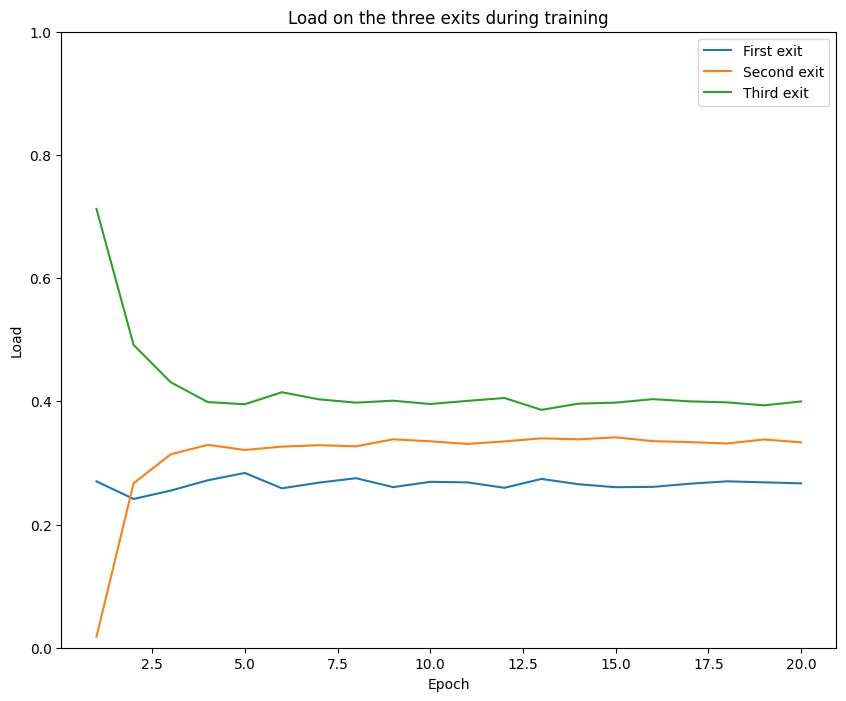

In [ ]:
x = range(1, 21)
plt.figure(figsize=(10, 8))

plt.plot(x, mean_prob_train_1, label='First exit')
plt.plot(x, mean_prob_train_2, label='Second exit')
plt.plot(x, mean_prob_train_3, label='Third exit')

plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Load')
plt.title('Load on the three exits during training')
plt.legend()
plt.show()

Since, as I wrote in the description of the model, at the time of inference we use an argmax applied to $p_i$, it is enough that one of the three output probabilities is even one decimal place greater than the others to be chosen. We therefore have to take these results with a grain of salt, but in any case we can see that there is no strong prevalence of one output over another.

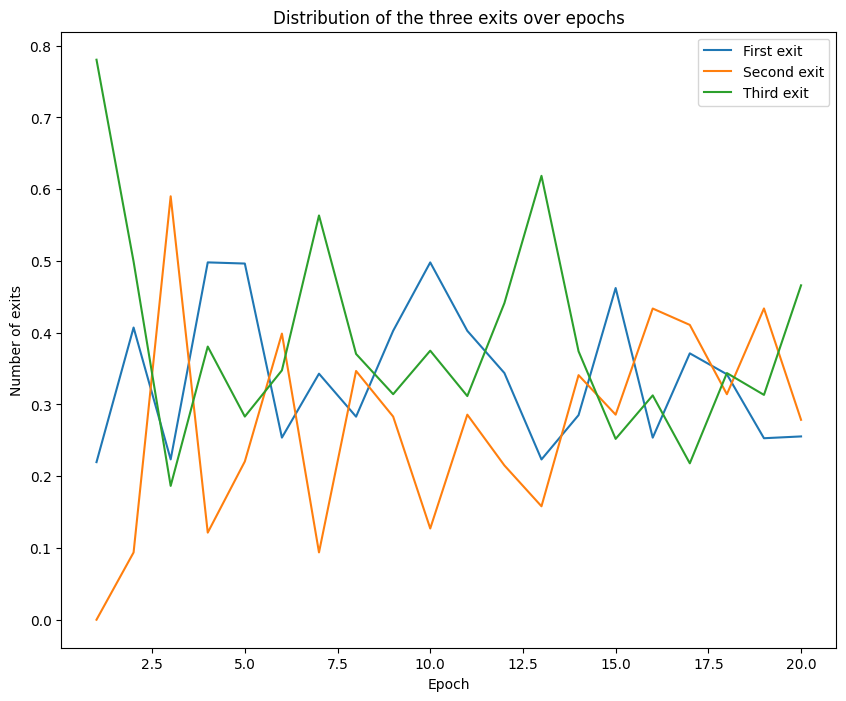

In [ ]:
x = range(1, 21)
plt.figure(figsize=(10, 8))

plt.plot(x, n_exit_1, label='First exit')
plt.plot(x, n_exit_2, label='Second exit')
plt.plot(x, n_exit_3, label='Third exit')

plt.xlabel('Epoch')
plt.ylabel('Number of exits')
plt.title('Distribution of the three exits over epochs')
plt.legend()
plt.show()

From the following 3 plots, we can state that the network has been trained correctly, in fact the accuracy rises in both sets and the loss decreases. However, it is likely that training the net for another 20 to 30 epochs would have increased performance a little, but due to the limitations of colab I could not do so (I ran out of the calculation units I had on my colab pro account and the free gpu that colab offers).

(In the graph below, the train accuracy is reported in a noisy way. The error is due to the fact that in the list I output I saved only the training accuracy of the last batch for each epoch. I fixed the error in the code, but unfortunately at the moment I have neither the resources of Colab to redo the entire model train to correct the plot, neither the time)

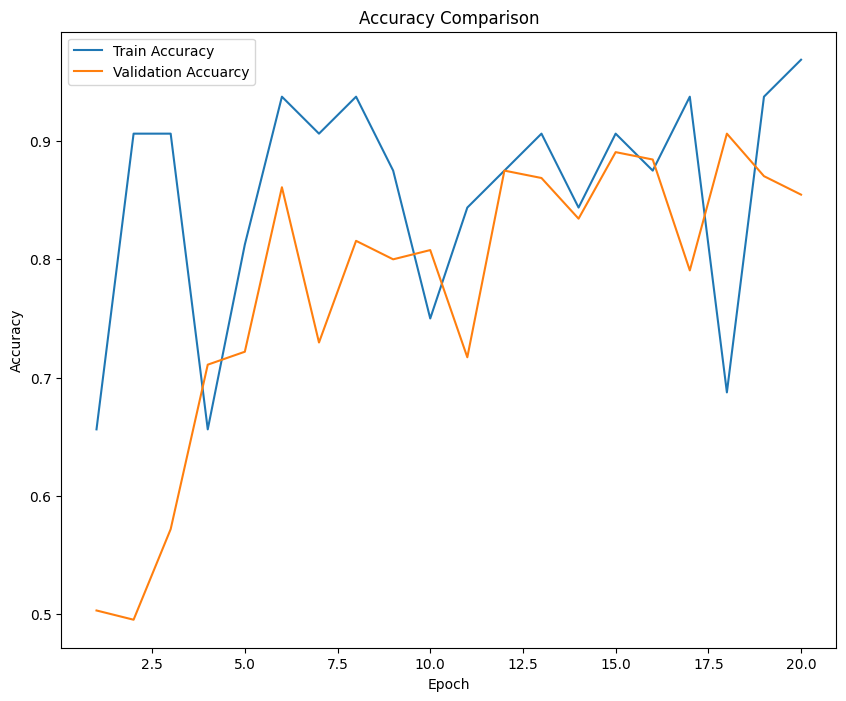

In [ ]:
x = range(1, 21)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 21), train_accuracy_epochs, label='Train Accuracy')
plt.plot(range(1, 21), val_accuracy_epochs, label='Validation Accuarcy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

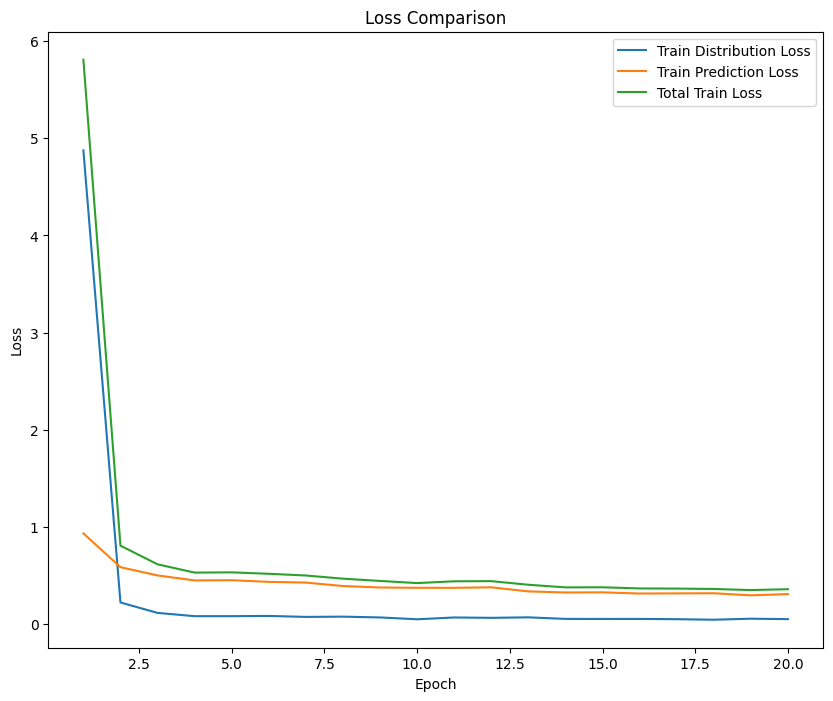

In [ ]:
x = range(1, 21)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 21), train_loss_epochs_distr, label='Train Distribution Loss')
plt.plot(range(1, 21), train_loss_epochs_preds, label='Train Prediction Loss')
plt.plot(range(1, 21), train_Total_loss_epochs, label='Total Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.show()

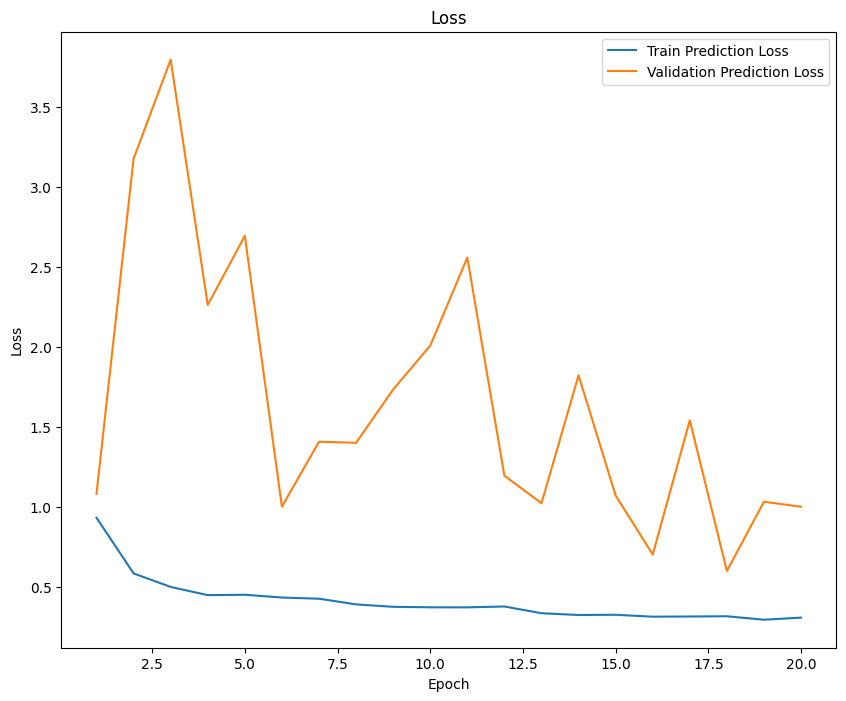

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 21), train_loss_epochs_preds, label='Train Prediction Loss')
plt.plot(range(1, 21), val_loss_epochs_preds, label='Validation Prediction Loss')

plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# loading of the best model
model_balanced.load_weights('/content/drive/MyDrive/NNDS/model2')

Finally, as in the previous point, I also evaluated the best model of the validation set in the test set, obtaining an accuracy of 83,5%. The performances are still good with 20 epochs.

In conclusion, it can be said that the addition of the regularization term balanced the distribution of outputs.

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()

for x_test, y_test in val_dataset_p:
  test_predictions = model_balanced(x_test, training = False)
  test_accuracy.update_state(tf.argmax(y_test, axis = 1), tf.argmax(test_predictions[0], axis = -1) )

print("Accuracy : %.4f "% test_accuracy.result())

Accuracy : 0.8359 


### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

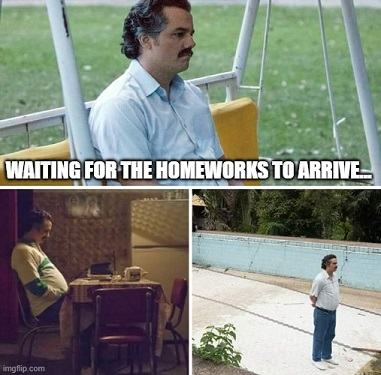